In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

In [2]:
links = pd.read_csv('/Users/max/Downloads/àå¨¢/links.csv')
movies = pd.read_csv('/Users/max/Downloads/àå¨¢/movies.csv')
ratings = pd.read_csv('/Users/max/Downloads/àå¨¢/ratings.csv')
tags = pd.read_csv('/Users/max/Downloads/àå¨¢/tags.csv')

In [3]:
ratings_with_movies = ratings.join(movies.set_index('movieId'), on='movieId')

In [4]:
ratings_with_movies.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [5]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [6]:
r_g_t = pd.merge(ratings_with_movies, tags,  how='left', left_on=['userId','movieId'], right_on = ['userId','movieId'])

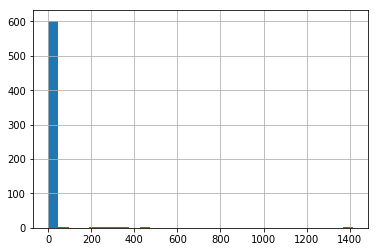

In [9]:
r_g_t.groupby('userId').tag.count().hist(bins=30)

In [10]:
r_g_t.groupby('userId').tag.count().max()

1414

In [11]:
r_g_t.groupby('userId').tag.count().sort_values(ascending=False).head(7)

userId
474    1414
567     432
62      370
599     323
477     267
424     223
537      90
Name: tag, dtype: int64

In [12]:
r_g_t = r_g_t.query('userId != 474')

In [13]:
r_g_t.groupby('movieId').tag.count().max()

180

In [14]:
r_g_t.groupby('movieId').tag.count().sort_values(ascending=False).head(7)

movieId
296     180
2959     53
924      39
293      34
1732     31
7361     29
4878     27
Name: tag, dtype: int64

In [15]:
r_g_t = r_g_t.query('movieId != 296')

In [16]:
r_g_t['tag'] = r_g_t['tag'].fillna('notagged')

In [17]:
r_g_t = r_g_t.rename(columns={'rating': 'target_rating'})

In [18]:
r_g_t.head(2) #ratings_genres_tags

,userId,movieId,target_rating,timestamp_x,title,genres,tag,timestamp_y
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,notagged,NaN
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance,notagged,NaN


In [19]:
mean_r_user = r_g_t.groupby('userId').target_rating.mean().reset_index(name ='mean_r_user')

In [20]:
mean_r_movie = r_g_t.groupby('movieId').target_rating.mean().reset_index(name ='mean_r_movie')

In [21]:
var_r_user = r_g_t.groupby('userId').target_rating.var().reset_index(name ='var_r_user')

In [22]:
var_r_movie = r_g_t.groupby('movieId').target_rating.var().reset_index(name ='var_r_movie')

In [23]:
r_g_t_1 = pd.merge(r_g_t, mean_r_user,  how='left', left_on=['userId'], right_on = ['userId'])

In [24]:
r_g_t_2 = pd.merge(r_g_t_1, var_r_user,  how='left', left_on=['userId'], right_on = ['userId'])

In [25]:
r_g_t_3 = pd.merge(r_g_t_2, mean_r_movie,  how='left', left_on=['movieId'], right_on = ['movieId'])

In [26]:
r_g_t_4 = pd.merge(r_g_t_3, var_r_movie,  how='left', left_on=['movieId'], right_on = ['movieId'])

In [27]:
r_g_t_4.isnull().sum()

userId               0
movieId              0
target_rating        0
timestamp_x          0
title                0
genres               0
tag                  0
timestamp_y      97939
mean_r_user          0
var_r_user           0
mean_r_movie         0
var_r_movie       3358
dtype: int64

In [28]:
r_g_t_4['var_r_movie'] = r_g_t_4['var_r_movie'].fillna(r_g_t_4['var_r_movie'].median())

In [29]:
def change_string(s):
    return ' '.join(s.replace(' ', '').replace('-', '').split('|'))

In [30]:
movie_genres = [change_string(g) for g in r_g_t.genres.values]

In [31]:
tfidf_vectorizer_genres = TfidfVectorizer()
X_train_tfidf_genres = tfidf_vectorizer_genres.fit_transform(movie_genres)

In [32]:
#X_train_tfidf_genres.toarray()

In [33]:
def change_string_tags(s):
    return ' '.join(s.replace(' ', '').replace('-', ''))

In [34]:
user_movie_tags = [change_string(g) for g in r_g_t.tag.values]

In [35]:
tfidf_vectorizer_tags = TfidfVectorizer()
X_train_tfidf_tags = tfidf_vectorizer_tags.fit_transform(user_movie_tags)

In [36]:
len(tfidf_vectorizer_tags.vocabulary_) #- Очень много признаков получаем по тагам. Много признаков для модели не очень?

868

In [37]:
r_g_t.shape # - данных не так много относительно tf-idf по тэгам

(99821, 8)

In [38]:
X_train_tfidf_genres

<99821x20 sparse matrix of type '<class 'numpy.float64'>'
	with 272693 stored elements in Compressed Sparse Row format>

In [39]:
X_train_tfidf_tags

<99821x868 sparse matrix of type '<class 'numpy.float64'>'
	with 99845 stored elements in Compressed Sparse Row format>

In [40]:
from scipy.sparse import hstack
X_TFIDF = hstack((X_train_tfidf_genres, X_train_tfidf_tags))

In [41]:
r_g_t_4.head(1)

,userId,movieId,target_rating,timestamp_x,title,genres,tag,timestamp_y,mean_r_user,var_r_user,mean_r_movie,var_r_movie
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,notagged,NaN,4.372294,0.634707,3.920561,0.700233


In [42]:
X_columns = r_g_t_4.columns[8:12]
Y_column = r_g_t_4.columns[2]
X_columns, Y_column

(Index(['mean_r_user', 'var_r_user', 'mean_r_movie', 'var_r_movie'], dtype='object'),
 'target_rating')

In [43]:
X_R = r_g_t_4[X_columns]
Y = r_g_t_4[Y_column]

In [44]:
from scipy.sparse import hstack
X = hstack((X_TFIDF, X_R))

In [45]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=46)

In [46]:
X_train.shape, X_test.shape

((79856, 892), (19965, 892))

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

estimator = LinearRegression()
estimator.fit(X_train, Y_train)
#print('Weights: {}'.format(estimator.coef_))


y_pred = estimator.predict(X_test)

print("RMSE: \t", np.sqrt(mean_squared_error(Y_test, y_pred)))

RMSE: 	 0.898111499283541
